In [ ]:
# use dataset from Anime Face dataset 63000 faces

In [1]:
project_name = '06b-anime-dcgan'

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:14<00:00, 28.0MB/s]


In [4]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [5]:
print(os.listdir(DATA_DIR+'/images'))

['2527_2002.jpg', '10426_2005.jpg', '20265_2007.jpg', '11235_2005.jpg', '21002_2008.jpg', '20411_2007.jpg', '60983_2018.jpg', '25520_2009.jpg', '1327_2001.jpg', '10008_2004.jpg', '22377_2008.jpg', '33023_2011.jpg', '25677_2009.jpg', '26676_2009.jpg', '56416_2017.jpg', '33731_2011.jpg', '46888_2014.jpg', '55288_2016.jpg', '50097_2015.jpg', '59024_2018.jpg', '28594_2010.jpg', '58594_2017.jpg', '27056_2009.jpg', '62328_2019.jpg', '52500_2015.jpg', '33886_2011.jpg', '32720_2011.jpg', '35424_2011.jpg', '42897_2013.jpg', '22776_2008.jpg', '52062_2015.jpg', '39543_2012.jpg', '4722_2003.jpg', '44668_2013.jpg', '24320_2008.jpg', '9141_2004.jpg', '43333_2013.jpg', '42397_2013.jpg', '4249_2002.jpg', '46028_2014.jpg', '30955_2010.jpg', '21979_2008.jpg', '12279_2005.jpg', '40287_2012.jpg', '6917_2003.jpg', '2353_2001.jpg', '37579_2012.jpg', '55044_2016.jpg', '13154_2005.jpg', '32703_2011.jpg', '50257_2015.jpg', '46104_2014.jpg', '26007_2009.jpg', '62764_2019.jpg', '37696_2012.jpg', '45738_2014.jpg'

In [6]:
print(len(os.listdir(DATA_DIR+'/images')))

63565


In [7]:
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder # load dataset using image folder
import torchvision.transforms as T

In [75]:
image_size = 64
batch_size = 10
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # for mean and standard dev 0.5

In [76]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size), # to 64 X 64
    T.CenterCrop(image_size),
    T.ToTensor(),# convert to tensor
    T.Normalize(*stats)])) # range of pixel from 0,1 to -1,1

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)  # to load the data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [77]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
def denorm(img_tensors):  # make img to original range
    return img_tensors * stats[1][0] + stats[0][0]

In [79]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

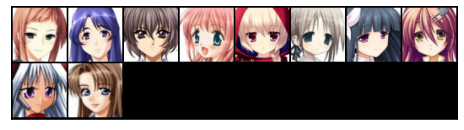

In [80]:
show_batch(train_dl)

In [81]:
def get_default_device():
   
    if torch.cuda.is_available():
        return torch.device('cuda')  # use Gpu 
    else:
        return torch.device('cpu')
    
def to_device(data, device): # Move tensor(s) to chosen device
   
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self): # for loop moving batch to gpu device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):

        return len(self.dl)

In [82]:
device = get_default_device() # gpu access
device

device(type='cuda')

In [83]:
train_dl = DeviceDataLoader(train_dl, device)

In [84]:
import torch.nn as nn

In [85]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # convolutional layer
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True), # activation function
    # out: 64 x 32 x 32             # stride = 2, 64/2=32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 64 input , 128 output
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16               # channel increase to 128 ,but size decrease 16 X 16 

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [86]:
discriminator = to_device(discriminator, device)

In [87]:
latent_size = 128

In [88]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512), # normalisation
    nn.ReLU(True),         # activation Function
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([10, 3, 64, 64])


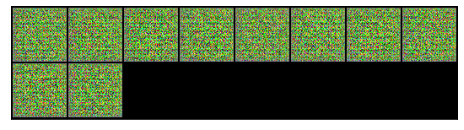

In [89]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)   # generator is not train , random noise

In [90]:
generator = to_device(generator, device)

In [91]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()  # rearranging weights of generator
    opt_d.step()   # update  weights of generator
    return loss.item(), real_score, fake_score

In [92]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()   # rearranging weights of discriminator
    opt_g.step()      # update  weights of discriminator
    
    return loss.item()

In [93]:
from torchvision.utils import save_image

In [94]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [95]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8) # 8 row in single image # denormalisation is use to convert 0,1
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [96]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


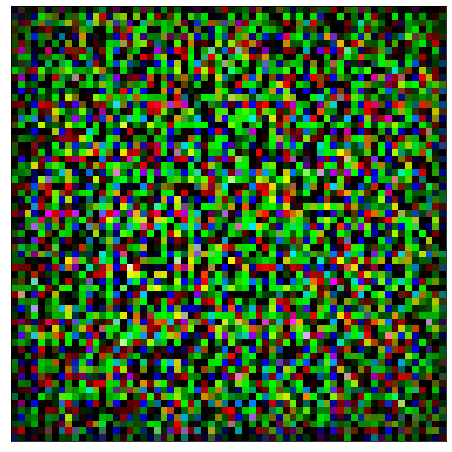

In [97]:
save_samples(0, fixed_latent)

In [98]:
from tqdm.notebook import tqdm   # utility function for progress bar 
import torch.nn.functional as F

In [99]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()       # clear ram of gpu
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []     # discriminator 
    fake_scores = []    # discriminator 
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    w=0
    for epoch in range(epochs):
        w=0
        for real_images, _ in tqdm(train_dl):
            w+=1
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            # if w>60000:
              # break
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [100]:
lr = 0.00013
epochs = 5

In [101]:
history = fit(epochs, lr)

  0%|          | 0/6357 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 12.1762, loss_d: 0.0229, real_score: 0.9792, fake_score: 0.0011
Saving generated-images-0001.png


  0%|          | 0/6357 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 14.4018, loss_d: 0.5480, real_score: 0.9273, fake_score: 0.3335
Saving generated-images-0002.png


  0%|          | 0/6357 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 13.3831, loss_d: 0.0010, real_score: 0.9995, fake_score: 0.0005
Saving generated-images-0003.png


  0%|          | 0/6357 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 8.4171, loss_d: 0.0546, real_score: 0.9623, fake_score: 0.0126
Saving generated-images-0004.png


  0%|          | 0/6357 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 5.7700, loss_d: 0.0281, real_score: 0.9997, fake_score: 0.0269
Saving generated-images-0005.png


In [102]:
losses_g, losses_d, real_scores, fake_scores = history

In [103]:
show_images()

TypeError: ignored

In [104]:
def show_image(n):
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
  n=int(input())
  for i in range(2):
    w=0
    for real_images, _ in train_dl:
      w+=1
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)        
      loss_g = train_generator(opt_g)
      if w>n:
        break

  save_samples(i+1, fixed_latent, show=True)


### Save the model checkpoints 

In [110]:

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import pickle
l_g=losses_g
l_d=losses_d
r_s=real_scores
f_s=fake_scores
file='my.pkl'
f_b=open(file,'wb')
pickle.dump(l_g,f_b)
f_b.close()

In [ ]:
file='my1.pkl'
f_b=open(file,'wb')
pickle.dump(l_d,f_b)
f_b.close()

In [ ]:
file='my2.pkl'
f_b=open(file,'wb')
pickle.dump(r_s,f_b)
f_b.close()

In [ ]:
file='my3.pkl'
f_b=open(file,'wb')
pickle.dump(f_s,f_b)
f_b.close()

In [ ]:
# Load model
generator.load_state_dict(torch.load('G.pth'))
discriminator.load_state_dict(torch.load('D.pth'))



<All keys matched successfully>

In [ ]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
type(discriminator)

torch.nn.modules.container.Sequential

In [106]:
from IPython.display import Image

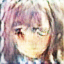

In [107]:
Image('./generated/generated-images-0001.png')

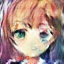

In [108]:
Image('./generated/generated-images-0005.png')

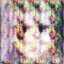

In [68]:
Image('./generated/generated-images-0040.png')

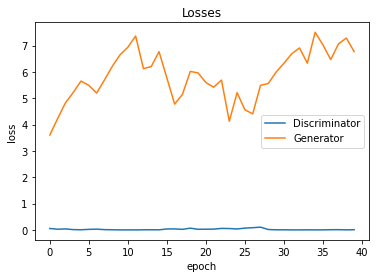

In [69]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

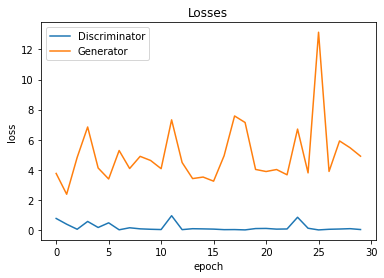

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

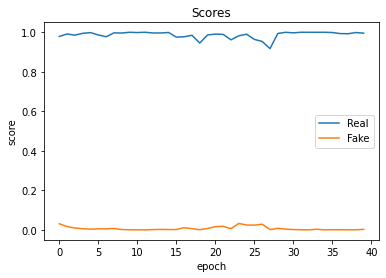

In [70]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

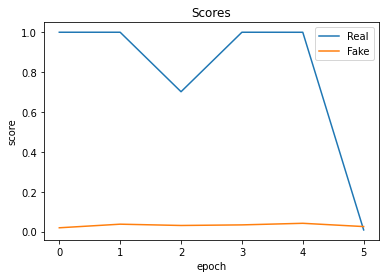

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

torch.Size([33, 3, 64, 64])


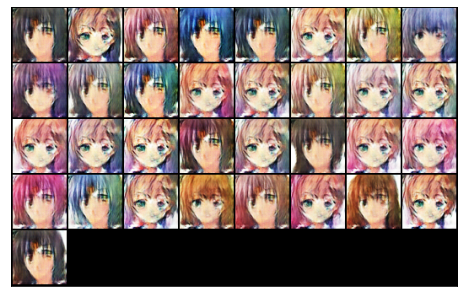

In [122]:
xb = torch.randn(33, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb.cuda())
print(fake_images.shape)
show_images(fake_images.cpu()) 